In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

num_iterations = 10000
num_simulations = 50

In [2]:
file_path = 'sim_results.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

In [3]:
### Define functions to parse results for analysis ###

def get_species_class_combo_counts(results):
    species_class_combo_counts = {}
    for i in range(num_simulations):
        for species in results[i][5]:
            for classe, count in results[i][5][species].items():

                if (species, classe) not in species_class_combo_counts:
                    species_class_combo_counts[(species, classe)] = []
                    species_class_combo_counts[(species, classe)].append(count)
                elif (species, classe) in species_class_combo_counts:
                    species_class_combo_counts[(species, classe)].append(count) 
                    
    return species_class_combo_counts

def get_species_background_combo_counts(results):
    species_background_combo_counts = {}
    for i in range(num_simulations):
        for species in results[i][6]:
            for background, count in results[i][6][species].items():

                if (species, background) not in species_background_combo_counts:
                    species_background_combo_counts[(species, background)] = []
                    species_background_combo_counts[(species, background)].append(count)
                elif (species, background) in species_background_combo_counts:
                    species_background_combo_counts[(species, background)].append(count) 
                    
    return species_background_combo_counts

def get_class_backgroud_combo_counts(results):
    class_background_combo_counts = {}
    for i in range(num_simulations):
        for classe in results[i][7]:
            for background, count in results[i][7][classe].items():

                if (classe, background) not in class_background_combo_counts:
                    class_background_combo_counts[(classe, background)] = []
                    class_background_combo_counts[(classe, background)].append(count)
                elif (classe, background) in species_class_combo_counts:
                    class_background_combo_counts[(classe, background)].append(count) 
                    
    return class_background_combo_counts

def get_counts(j):
    new_dict = {}
    for i in range(num_simulations):
        for item in results[i][j].items():
            if item[0] not in new_dict:
                new_dict[item[0]] = []
                new_dict[item[0]].append(item[1])
            elif item[0] in new_dict:
                new_dict[item[0]].append(item[1])
                
    return new_dict

In [4]:
species_selection_counts = get_counts(0)
class_selection_counts = get_counts(1)
background_selection_counts = get_counts(2)
alignment_selection_counts = get_counts(3)
dead_farmer_counts = get_counts(4)
species_class_combo_counts = get_species_class_combo_counts(results)
species_background_combo_counts = get_species_background_combo_counts(results)
class_background_combo_counts = get_class_backgroud_combo_counts(results)

In [5]:
def calculate_parameters(dictionary):
    means = {}
    variances = {}
    for key, value in dictionary.items():

        means[key] = np.mean(value)
        variances[key] = np.var(value)
        
    return means, variances



species_means, species_variances = calculate_parameters(species_selection_counts)
class_means, class_variances = calculate_parameters(class_selection_counts)
background_means, background_variances = calculate_parameters(background_selection_counts)
alignment_means, alignment_variances = calculate_parameters(alignment_selection_counts)
dead_farmer_means, dead_farmer_variances = calculate_parameters(dead_farmer_counts)
species_class_combo_means, species_class_combo_variances = calculate_parameters(species_class_combo_counts)
species_background_combo_means, species_background_combo_variances = calculate_parameters(species_background_combo_counts)
class_background_combo_means, class_background_combo_variances = calculate_parameters(class_background_combo_counts)

In [6]:
def calculate_CI(means, variances):
    CI_lower = {}
    CI_upper = {}
    CI = {}
    for key in means:
        CI[key] = (
            np.round(means[key] - (1.96 * (np.sqrt(variances[key]) / np.sqrt(num_simulations))), 2), 
            np.round(means[key] + (1.96 * (np.sqrt(variances[key]) / np.sqrt(num_simulations))), 2)
        )
    return CI

In [7]:
species_CI = calculate_CI(species_means, species_variances)
class_CI = calculate_CI(class_means, class_variances)
background_CI = calculate_CI(background_means, background_variances)
alignment_CI = calculate_CI(alignment_means, alignment_variances)
dead_farmer_CI = calculate_CI(dead_farmer_means, dead_farmer_variances)
species_class_CI = calculate_CI(species_class_combo_means, species_class_combo_variances)
species_background_CI = calculate_CI(species_background_combo_means, species_background_combo_variances)
class_background_CI = calculate_CI(class_background_combo_means, class_background_combo_variances)

In [8]:
def plot_results(
    CI_dictionary, 
    x,
    y,
    filename
):
    sorted_data = sorted(CI_dictionary.items(), key=lambda x: (x[1][0] + x[1][1]) / 2, reverse=True)
    species = [item[0] for item in sorted_data]
    means = [(lower + upper) / 2 for lower, upper in [item[1] for item in sorted_data]]
    ci_widths = [(upper - lower) / 2 for lower, upper in [item[1] for item in sorted_data]]

    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(species, means, yerr = ci_widths, capsize = 10)

    # add labels and formatting
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize =12)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    # plt.title('Species Means with Confidence Intervals (Descending Order)', fontsize=16)
    # plt.ylim(min(means) - 10, max(means) + 10)  # Zoom in on the y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    
def print_latex_table(

    CI_dictionary,
    x,
    pop = 10000,
):

    # Initialize a list to store the data
    data = []

    # Loop through each species to calculate mean value and percentage
    for key, (lower, upper) in CI_dictionary.items():
        # Calculate mean value and CI width
        mean_value = np.round((lower + upper) / 2, 0)
        ci_width = np.round((upper - lower) / 2, 0)
        mean_percentage = np.round((mean_value / pop) * 100, 2)
        ci_percentage = np.round((ci_width / pop) * 100, 2)

        # Format mean value as 'mean ± CI width'
        formatted_value = f'{mean_value:.0f} ± {ci_width:.0f}'
        formatted_percentage = f'{mean_percentage:.2f} ± {ci_percentage:.2f}%'

        # Store the species, mean count, and percentage
        data.append((key, formatted_value, formatted_percentage, mean_value))

    # Create a DataFrame and sort by mean value in descending order
    df = pd.DataFrame(data, columns=[x, 'Mean Count', 'Percentage of Population', 'Mean Value'])
    df = df.sort_values(by='Mean Value', ascending=False)

    # Drop the 'Mean Value' column used for sorting
    df = df.drop(columns=['Mean Value'])

    # Generate the LaTeX table
    latex_table = df.to_latex(index=False, column_format='l r r', caption='Mean Counts and Population Percentages of Adventurers')
    latex_table = latex_table.replace(r'{r}', '{l@{\hspace{0.3em}}r}')  # Align on '±' symbol

    print(latex_table)

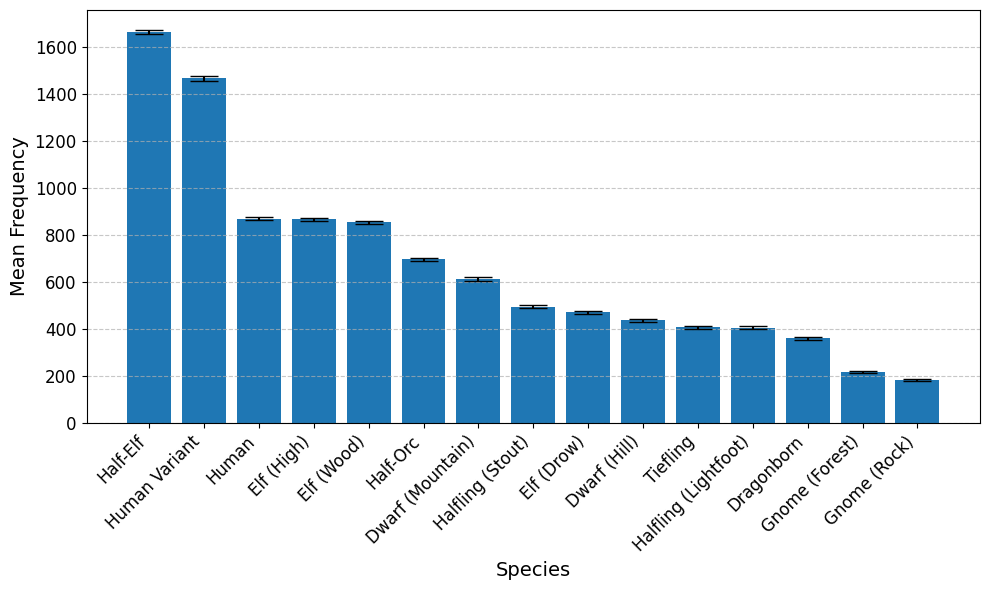

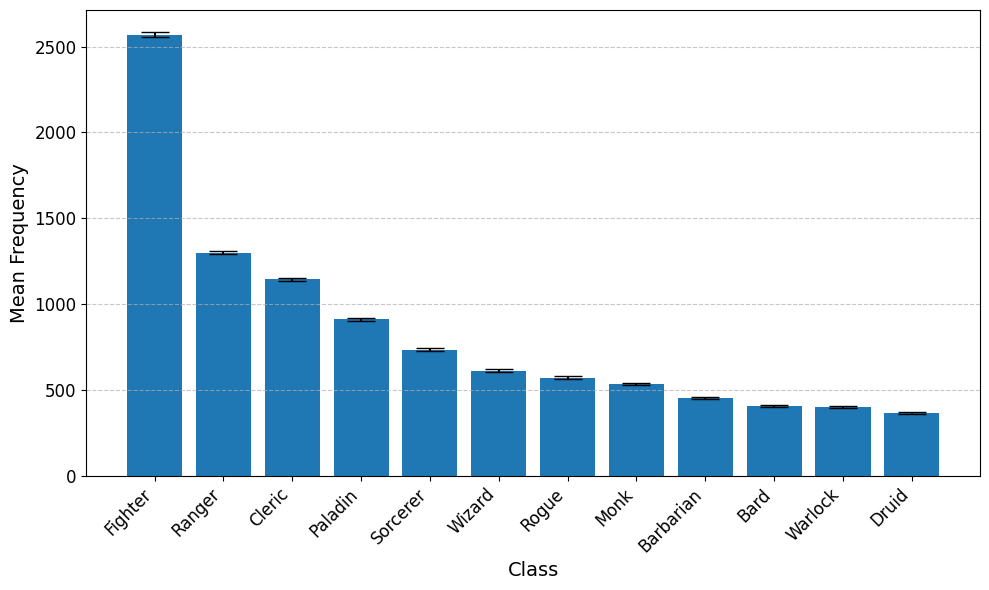

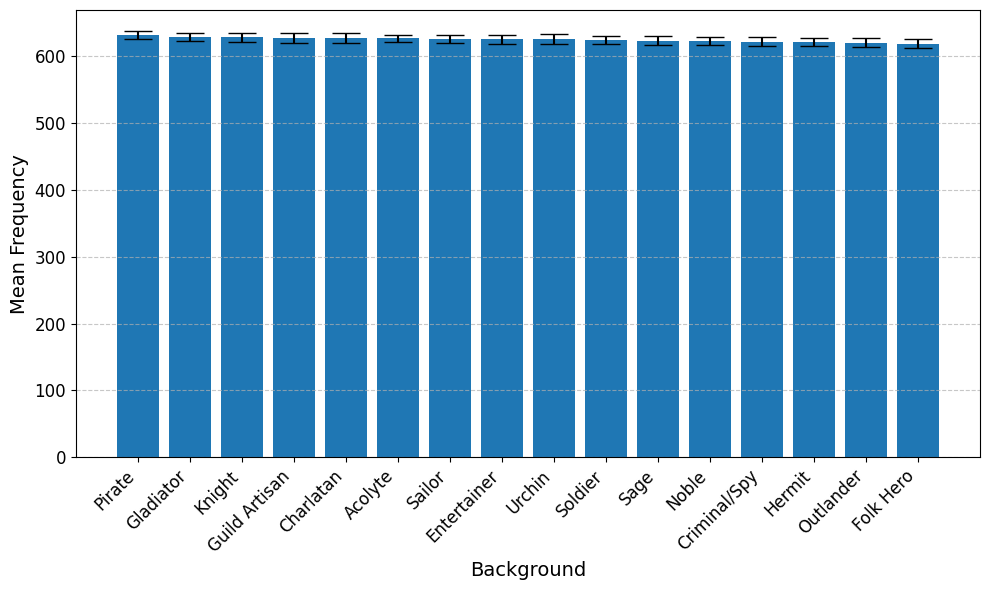

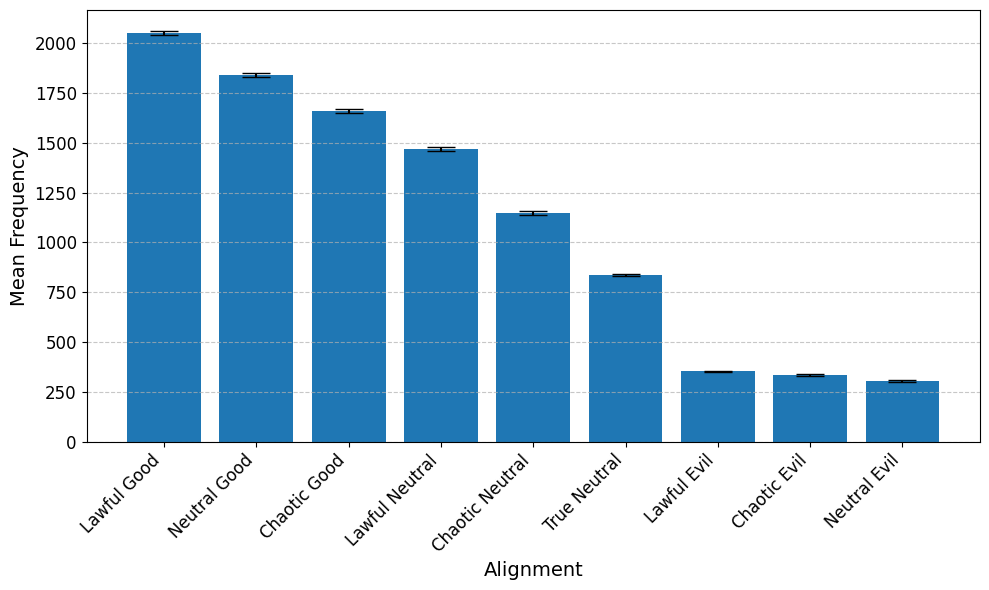

\begin{table}
\centering
\caption{Mean Counts and Population Percentages of Adventurers}
\begin{tabular}{l r r}
\toprule
             Species & Mean Count & Percentage of Population \\
\midrule
            Half-Elf &   1663 ± 8 &            16.63 ± 0.08\% \\
       Human Variant &  1466 ± 11 &            14.66 ± 0.11\% \\
               Human &    869 ± 8 &             8.69 ± 0.08\% \\
          Elf (High) &    866 ± 7 &             8.66 ± 0.07\% \\
          Elf (Wood) &    853 ± 7 &             8.53 ± 0.07\% \\
            Half-Orc &    696 ± 7 &             6.96 ± 0.07\% \\
    Dwarf (Mountain) &    612 ± 7 &             6.12 ± 0.07\% \\
    Halfling (Stout) &    494 ± 6 &             4.94 ± 0.06\% \\
          Elf (Drow) &    471 ± 7 &             4.71 ± 0.07\% \\
        Dwarf (Hill) &    437 ± 6 &             4.37 ± 0.06\% \\
            Tiefling &    406 ± 5 &             4.06 ± 0.05\% \\
Halfling (Lightfoot) &    406 ± 6 &             4.06 ± 0.06\% \\
          Dragonborn &    

In [9]:
plot_results(species_CI, x = 'Species', y = 'Mean Frequency', filename = 'results_species.png')
plot_results(class_CI, x = 'Class', y = 'Mean Frequency', filename = 'results_class.png')
plot_results(background_CI, x = 'Background', y = 'Mean Frequency', filename = 'results_background.png')
plot_results(alignment_CI, x = 'Alignment', y = 'Mean Frequency', filename = 'results_alignment.png')




print_latex_table(species_CI, 'Species')
print_latex_table(class_CI, 'Class')
print_latex_table(background_CI, 'Background')
print_latex_table(alignment_CI, 'Alignment')

In [10]:
def build_combination_df(
    CI_dictionary, x, y
):
    
    id1 = []    # x
    id2 = []    # y
    id3 = []    # mean of CI
    id4 = []    # CI width
    
    for (i, j), (k, l) in CI_dictionary.items():
        id1.append(i)
        id2.append(j)
        id3.append((k + l) / 2)
        id4.append(l - k)
        
    df = pd.DataFrame({
        x: id1,
        y: id2,
        'Mean': id3,
        'CI': id4
    })
    return df

In [11]:
species_class_df = build_combination_df(species_class_CI, x = 'Species', y = 'Class')

species_background_df = build_combination_df(species_background_CI, x = 'Species', y = 'Background')

class_background_df = build_combination_df(class_background_CI, x = 'Class', y = 'Background')

In [12]:
species_class_df

,Species,Class,Mean,CI
0,Tiefling,Sorcerer,98.420,6.06
1,Tiefling,Wizard,80.460,5.44
2,Tiefling,Rogue,10.660,1.74
3,Tiefling,Bard,40.660,3.08
4,Tiefling,Warlock,41.820,3.02
...,...,...,...,...
175,Dragonborn,Barbarian,19.480,2.52
176,Dragonborn,Fighter,70.320,5.10
177,Dragonborn,Rogue,2.865,0.83
178,Dragonborn,Monk,2.615,0.69


In [13]:
def run_chi_sq(df, x, y):
    contingency_table = df.pivot(index=y, columns=x, values='Mean').fillna(0)
    X_order = contingency_table.sum(axis=1).sort_values(ascending=False).index
    Y_order = contingency_table.sum(axis=0).sort_values(ascending=False).index
    contingency_table_sorted = contingency_table.loc[X_order, Y_order]
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table_sorted)
    print(f"Chi-squared: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print(f"Expected frequencies:\n{expected}")
    observed = contingency_table_sorted.values
    residuals = (observed - expected) / np.sqrt(expected)
    residuals_df = pd.DataFrame(residuals, index=contingency_table_sorted.index, columns=contingency_table_sorted.columns)
    significant_residuals = residuals_df[(residuals_df > 2) | (residuals_df < -2)]
    significant_residuals = np.round(significant_residuals, 0)
    
    return contingency_table_sorted, significant_residuals

In [14]:
def plot_contingency_table(df, x, y, filename):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create the heatmap
    cax = ax.imshow(contingency_table_sorted, cmap='coolwarm', vmin=0, vmax=np.max(contingency_table_sorted.values))

    # Add the colorbar with the correct 'mappable' argument
    cbar = fig.colorbar(cax, shrink=0.75)

    # Customize colorbar ticks and font size
    for label in cbar.ax.get_yticklabels():
        label.set_fontsize(14)

    # Customize the x and y axis labels and their font size
    plt.xticks(np.arange(len(contingency_table_sorted.columns)), contingency_table_sorted.columns, rotation=45, ha='right', fontsize=14)
    plt.yticks(np.arange(len(contingency_table_sorted.index)), contingency_table_sorted.index, fontsize=14)

    # Set plot title and axis labels
    plt.title('Adventurer Demographics', fontsize=20)
    plt.ylabel(y, fontsize=17)
    plt.xlabel(x, fontsize=17)

    # Annotate the cells with the values
    for i in range(len(contingency_table_sorted.index)):
        for j in range(len(contingency_table_sorted.columns)):
            value = contingency_table_sorted.iloc[i, j]
            ax.text(j, i, f'{value:.0f}', ha='center', va='center', color='black')

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    
    
def plot_significant_residuals(df, x, y, filename):

    fig, ax = plt.subplots(figsize=(12, 10))
    cax = ax.imshow(significant_residuals, cmap='coolwarm', vmin=-5, vmax=5)
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink = 0.75)
    cbar.set_ticks([-5,0, 5])  
    cbar.set_ticklabels(['Very Few', 'Common', 'A Lot'])  # Set custom labels
    for label in cbar.ax.get_yticklabels():
        label.set_fontsize(14)  
    plt.xticks(np.arange(len(significant_residuals.columns)), labels = significant_residuals.columns, fontsize = 14)
    plt.yticks(np.arange(len(significant_residuals.index)), labels = significant_residuals.index, fontsize = 14)
    plt.ylabel(y, fontsize = 17)
    plt.xlabel(x, fontsize = 17)
    ax.set_title('Adventurer Demographics Significance', fontsize = 20)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()



Chi-squared: 4419.62943412949
P-value: 0.0
Degrees of freedom: 154
Expected frequencies:
[[427.36044019 376.56103042 223.14537413 222.39001168 219.10649733
  178.8975775  157.31065453 126.8649229  120.90423958 112.38457324
  104.38903596 104.28883482  92.85048906  55.98417656  47.5621421 ]
 [215.83863975 190.1823682  112.69970145 112.3182052  110.65986436
   90.35232593  79.44983789  64.07320336  61.06275677  56.75989431
   52.72174354  52.67113689  46.89419369  28.27484105  24.02128763]
 [190.05733133 167.46562806  99.23804432  98.90211671  97.44185994
   79.55999892  69.9597819   56.41984241  53.76898505  49.98008721
   46.42428201  46.37972018  41.29281633  24.89749212  21.1520135 ]
 [151.56163409 133.54583096  79.13759525  78.86970904  77.7052241
   63.44529496  55.78958092  44.99212659  42.8781946   39.85672974
   37.02114511  36.98560918  32.92904659  19.85455949  16.86771938]
 [122.18351387 107.65982425  63.79787025  63.58191007  62.64314437
   51.14730468  44.9755446   36.27102

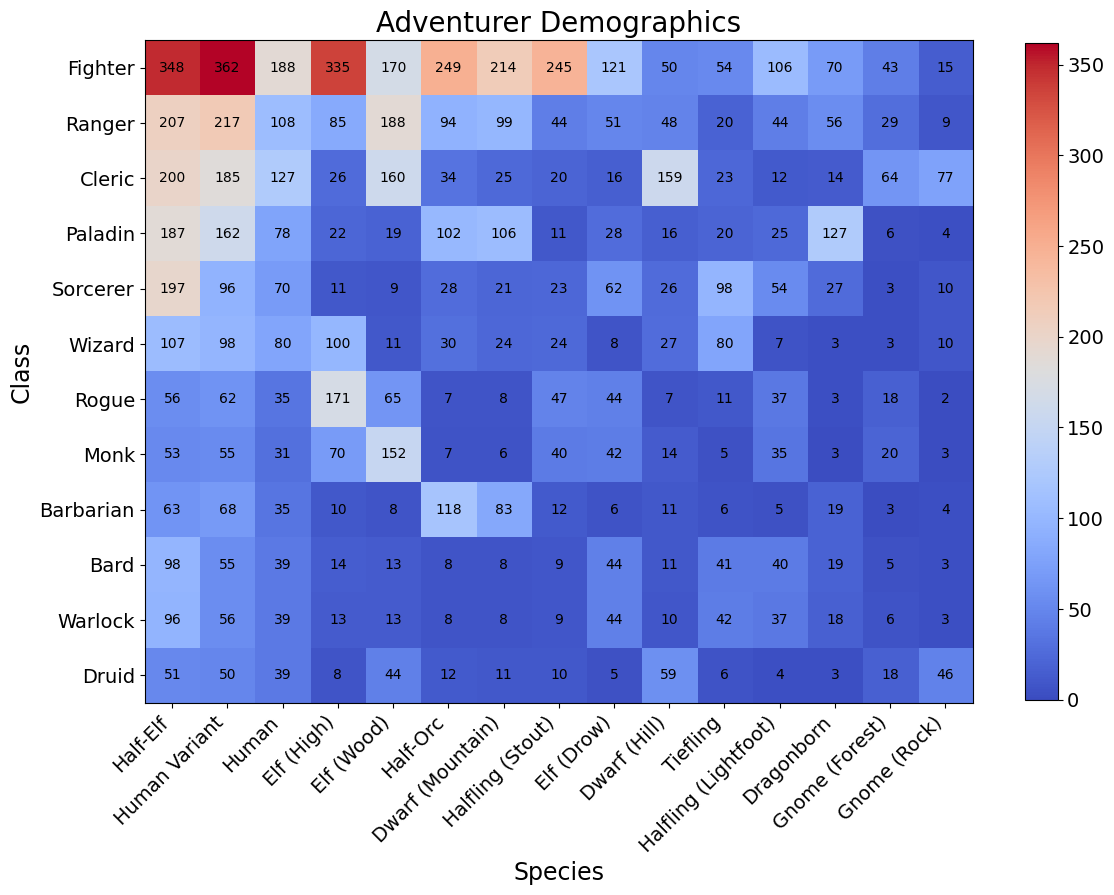

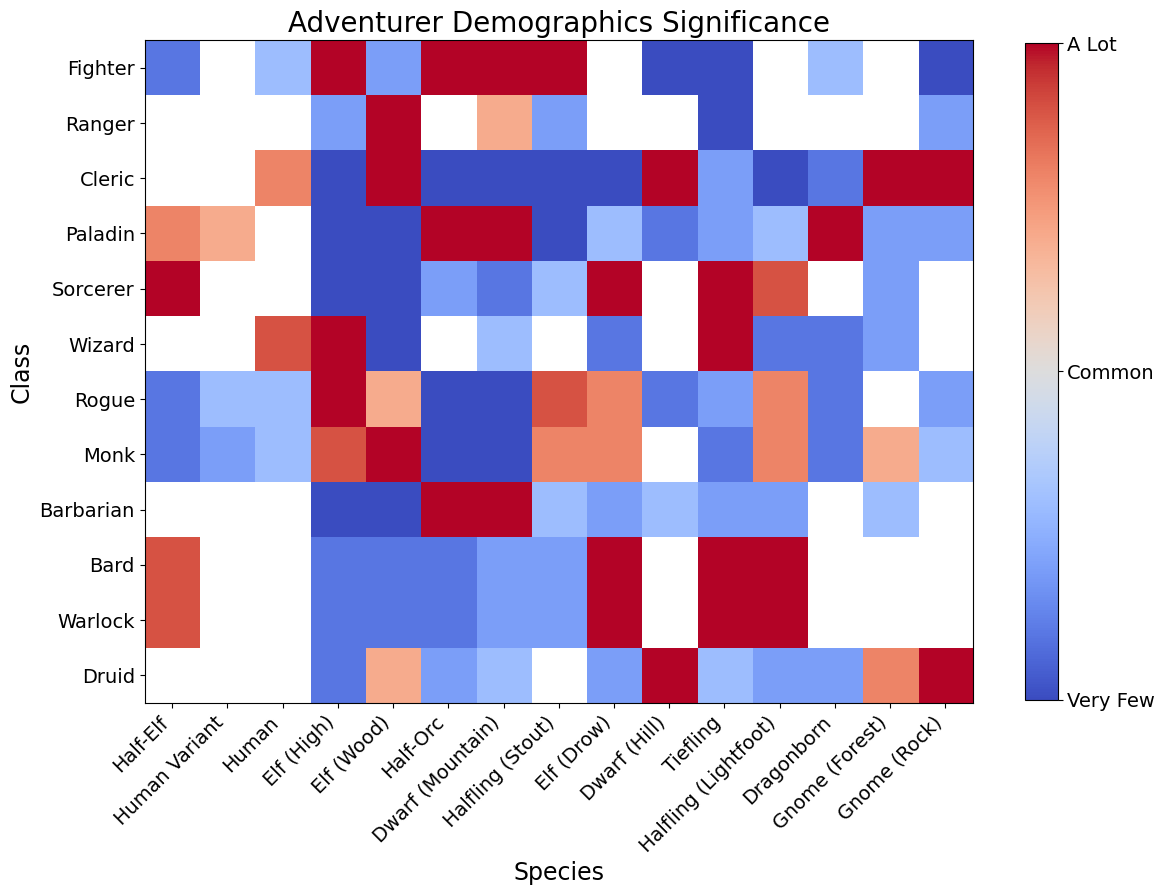

Chi-squared: 4.2100771145173415
P-value: 1.0
Degrees of freedom: 210
Expected frequencies:
[[105.01789696  92.53464704  54.83487872  54.64925888  53.8423808
   43.9615968   38.65691008  31.17529408  29.71053888  27.61694912
   25.6521568   25.6205888   22.74663808  13.73334272  11.60692224]
 [104.59873024  92.16530576  54.61601168  54.43113272  53.6274752
   43.7861292   38.50261552  31.05086152  29.59195272  27.50671928
   25.5497692   25.5183272   22.65584752  13.67852768  11.56059456]
 [104.53219584  92.10668016  54.58127088  54.39650952  53.5933632
   43.7582772   38.47812432  31.03111032  29.57312952  27.48922248
   25.5335172   25.5020952   22.64143632  13.66982688  11.55324096]
 [104.40245376  91.99236024  54.51352632  54.32899428  53.5268448
   43.7039658   38.43036648  30.99259548  29.53642428  27.45510372
   25.5018258   25.4704428   22.61333448  13.65286032  11.53890144]
 [104.37916672  91.97184128  54.50136704  54.31687616  53.5149056
   43.6942176   38.42179456  30.9856825

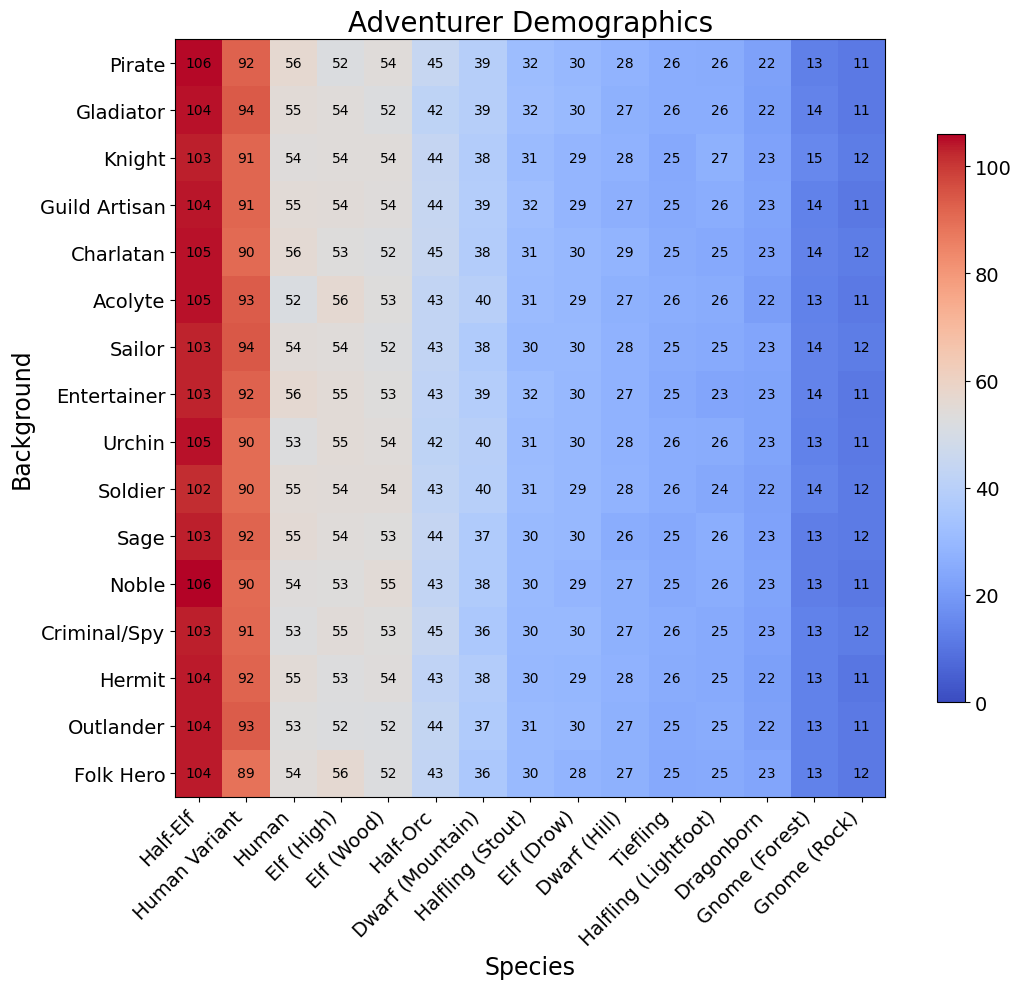

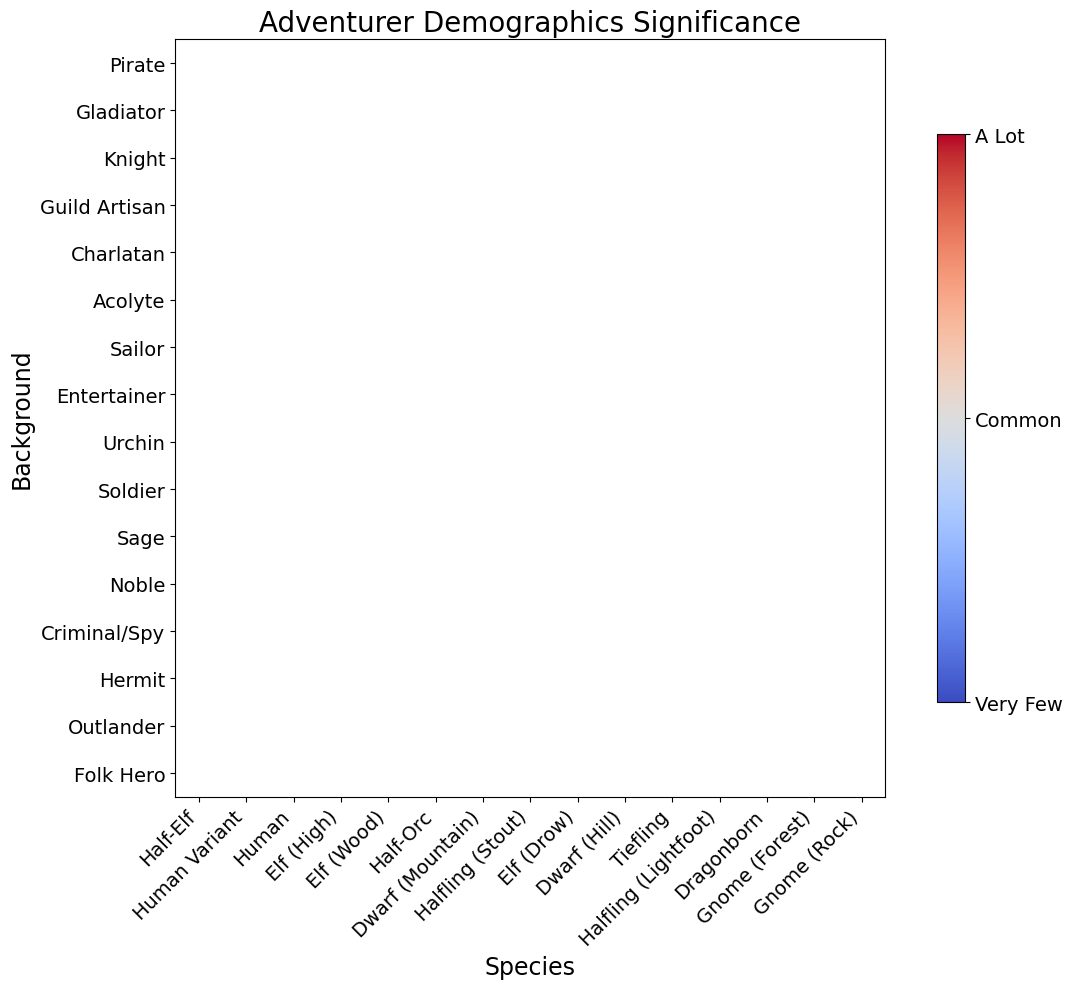

Chi-squared: 203.08295998310763
P-value: 0.023300533337666164
Degrees of freedom: 165
Expected frequencies:
[[167.508   85.668   73.524   59.004   48.378   45.474   38.082   35.244
   31.548   27.126   24.618   23.826 ]
 [165.9852  84.8892  72.8556  58.4676  47.9382  45.0606  37.7358  34.9236
   31.2612  26.8794  24.3942  23.6094]
 [164.4624  84.1104  72.1872  57.9312  47.4984  44.6472  37.3896  34.6032
   30.9744  26.6328  24.1704  23.3928]
 [163.1934  83.4614  71.6302  57.4842  47.1319  44.3027  37.1011  34.3362
   30.7354  26.4273  23.9839  23.2123]
 [160.9092  82.2932  70.6276  56.6796  46.4722  43.6826  36.5818  33.8556
   30.3052  26.0574  23.6482  22.8874]
 [160.9092  82.2932  70.6276  56.6796  46.4722  43.6826  36.5818  33.8556
   30.3052  26.0574  23.6482  22.8874]
 [160.1478  81.9038  70.2934  56.4114  46.2523  43.4759  36.4087  33.6954
   30.1618  25.9341  23.5363  22.7791]
 [159.3864  81.5144  69.9592  56.1432  46.0324  43.2692  36.2356  33.5352
   30.0184  25.8108  23.4244

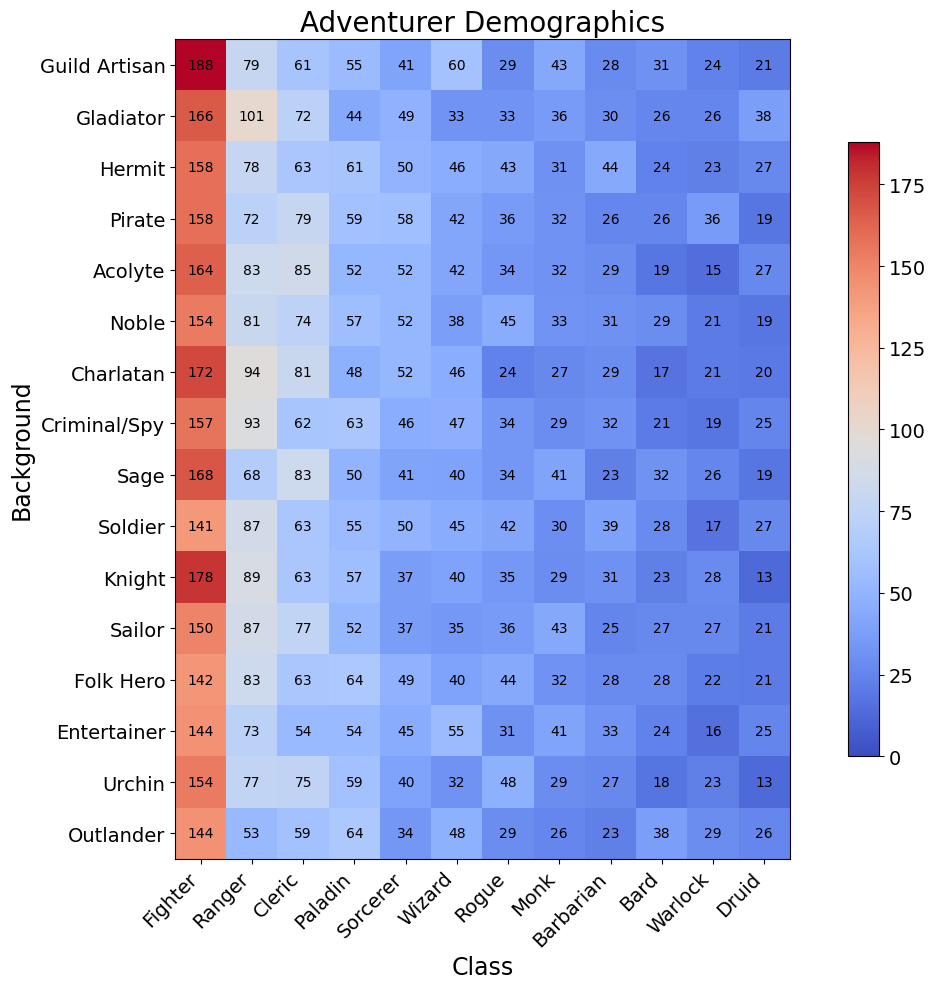

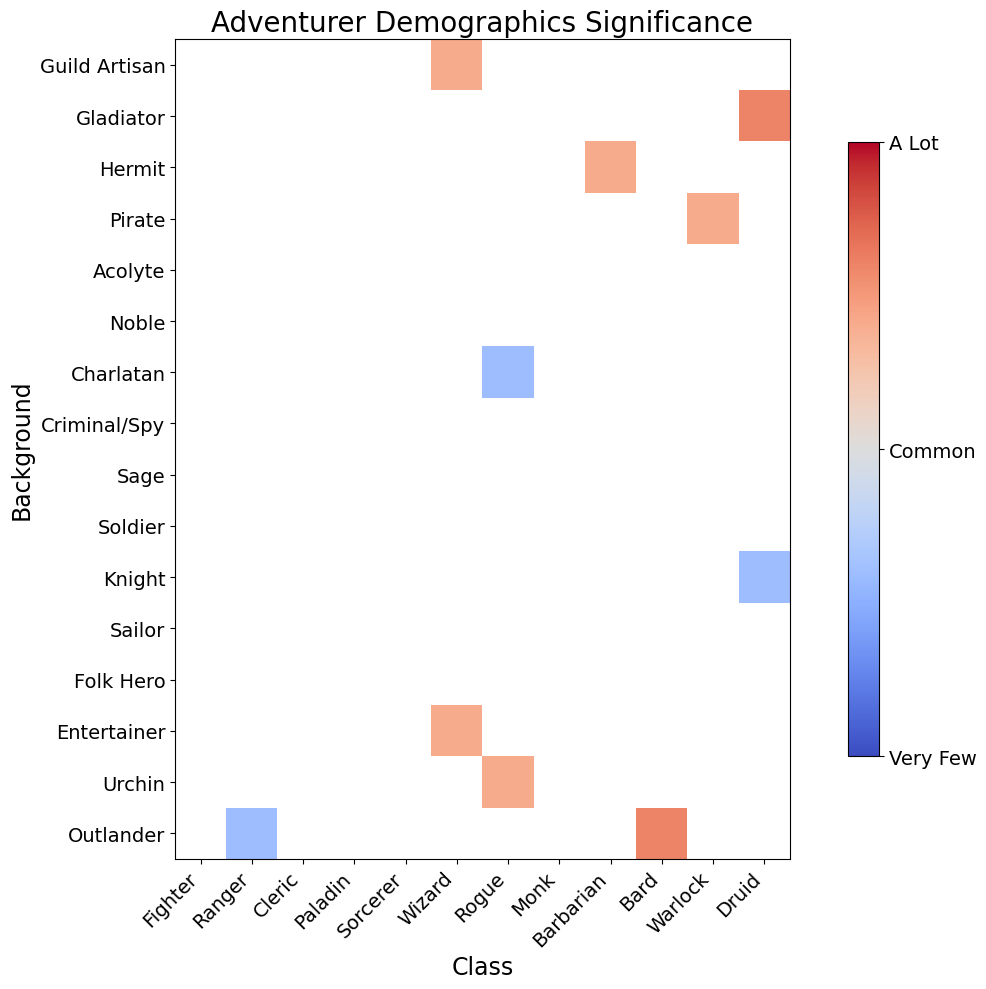

In [15]:
contingency_table_sorted, significant_residuals = run_chi_sq(species_class_df, x = 'Species', y = 'Class')
plot_contingency_table(contingency_table_sorted, x = 'Species', y = 'Class', filename = 'combo_species_class.png')
plot_significant_residuals(significant_residuals, x = 'Species', y = 'Class', filename = 'chisq_resid_species_class.png')


contingency_table_sorted, significant_residuals = run_chi_sq(species_background_df, x = 'Species', y = 'Background')
plot_contingency_table(contingency_table_sorted, x = 'Species', y = 'Background', filename = 'combo_species_background.png')
plot_significant_residuals(significant_residuals, x = 'Species', y = 'Background', filename = 'chisq_resid_species_background.png')


contingency_table_sorted, significant_residuals = run_chi_sq(class_background_df, x = 'Class', y = 'Background')
plot_contingency_table(contingency_table_sorted, x = 'Class', y = 'Background', filename = 'combo_class_background.png')
plot_significant_residuals(significant_residuals, x = 'Class', y = 'Background', filename = 'chisq_resid_class_background.png')